In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')

from src.analysis.stats import ols_comparison
from src.analysis.misc import (set_plot_style, add_significance)

# in
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
sila_dir = os.path.join(data_dir, 'sila', 'out')

df_xs_fname = os.path.join(data_dir, 'datasets', 'bf2_tau_asymmetry_ad_t_xs_tnic_fnc.csv')

# out
media_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'media'))
plot_dir = os.path.join(media_dir, '_plots')
os.makedirs(plot_dir, exist_ok=True)

In [2]:
rois = ['global', 'temporal_meta', 'early_amyloid', 'intermediate_amyloid', 'late_amyloid']

# read main df
df = pd.read_csv(df_xs_fname, index_col=0, low_memory=False)
for roi in rois:
    # read SILA results for both hemispheres
    df_ac_left = pd.read_csv(os.path.join(sila_dir, f'sila_out_fnc_{roi}_left.csv'))
    df_ac_right = pd.read_csv(os.path.join(sila_dir, f'sila_out_fnc_{roi}_right.csv'))
    df_ac_left = df_ac_left.rename(columns={'subid': 'sid', 'estdtt0': 'est_ab_yrs'})[['sid', 'age', 'est_ab_yrs']]
    df_ac_right = df_ac_right.rename(columns={'subid': 'sid', 'estdtt0': 'est_ab_yrs'})[['sid', 'age', 'est_ab_yrs']]
    df_ac_left['sid'] = 'BF' + df_ac_left['sid'].astype(str)
    df_ac_right['sid'] = 'BF' + df_ac_right['sid'].astype(str)
    df_ac = pd.merge(df_ac_left, df_ac_right, on=['sid', 'age'], how='inner', suffixes=[f'_{roi}_left', f'_{roi}_right'])
    df_ac[f'est_ab_yrs_diff_{roi}'] = df_ac[f'est_ab_yrs_{roi}_right'] - df_ac[f'est_ab_yrs_{roi}_left']
    df_ac[f'est_ab_yrs_diff_{roi}_abs'] = df_ac[f'est_ab_yrs_diff_{roi}'].abs()

    # merge main df and SILA
    df = df.merge(df_ac, how='left', on=['sid', 'age'])
print(f"N (xs+SILA merged) = {df.shape}")

N (xs+SILA merged) = (452, 3207)


global: LA = 1.68; S = 1.3; RA = 2.45 years
temporal_meta: LA = 2.51; S = 1.58; RA = 3.12 years
early_amyloid: LA = 1.87; S = 1.27; RA = 1.56 years
intermediate_amyloid: LA = 2.43; S = 1.26; RA = 2.19 years
late_amyloid: LA = 2.65; S = 1.5; RA = 1.84 years


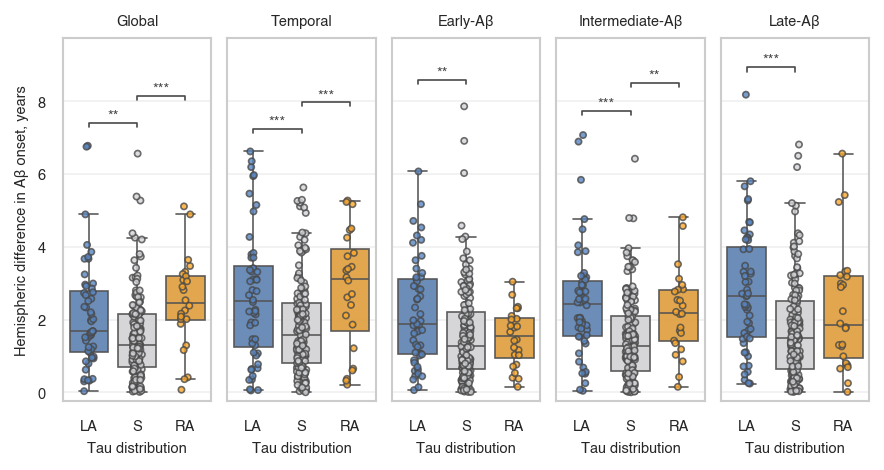

In [3]:
### plotting

set_plot_style(dpi=150)

fig, axs = plt.subplots(1, 5, figsize=(150/25.4, 80/25.4))

strip_kwargs = dict(linewidth=0.8, size=3, alpha=0.8, edgecolor='#494949')
scatter_kwargs = dict(s=10, lw=0.8, alpha=0.8)
line_kwargs = dict(alpha=0.9, lw=0.8, linestyle='--')
box_kwargs = dict(alpha=0.95, lw=0.8)
pval_kwargs = dict(lw=0.8, fontsize=7, col='#494949', h_coef=0.015, y_coef=0.1)

grp_order = ['LA', 'S', 'RA']
grp_markers = {'LA': 'o', 'LA-S': 'X', 'S': 'o', 'RA-S': 'X', 'RA': 'o'}
grp_colors = {'LA': '#5785C1FF', 'LA-S': '#ff6961', 'S': '#D3D4D8FF', 'RA-S': '#ff6961', 'RA': '#FBA72AFF'}
grp_comparisons = [('S', 'LA'), ('S', 'RA'), ('LA', 'RA')]
covars = ['age', 'gender_baseline_variable']

grp_col = 'temporal_meta_tau_asymmetry_group'

roinames = {'global': 'Global', 'temporal_meta': 'Temporal', 'early_amyloid': 'Early-Aβ', 
            'intermediate_amyloid': 'Intermediate-Aβ', 'late_amyloid': 'Late-Aβ'}

vminmax = [-0.25, 9.75]
for i, roi in enumerate(rois):
    y = f'est_ab_yrs_diff_{roi}_abs'
    df_r = df.dropna(subset=y)

    data = {
        'LA': df_r.loc[df_r[grp_col]=='LA', y].to_numpy(),
        'S': df_r.loc[df_r[grp_col]=='S', y].to_numpy(),
        'RA': df_r.loc[df_r[grp_col]=='RA', y].to_numpy(),
    }
    dfs_covars = {
        'LA': df_r.loc[df_r[grp_col]=='LA', covars],
        'S': df_r.loc[df_r[grp_col]=='S', covars],
        'RA': df_r.loc[df_r[grp_col]=='RA', covars],
    }

    data_args = dict(ax=axs[i], y=y, x=grp_col, data=df_r, order=grp_order, palette=grp_colors)
    sns.boxplot(**data_args, showfliers=False)
    sns.stripplot(**data_args, **strip_kwargs)
    axs[i].set_xlabel('Tau distribution')
    if i > 0:
        axs[i].set_ylabel('')  # Remove y-axis label
        axs[i].set_yticklabels([])
    else:
        axs[i].set_ylabel('Hemispheric difference in Aβ onset, years')
    axs[i].set_title(f'{roinames[roi]}')

    for box in axs[i].patches:
        box.set_linewidth(box_kwargs['lw'])
        box.set_alpha(box_kwargs['alpha'])
    for line in axs[i].lines:
        line.set_linewidth(box_kwargs['lw'])
        line.set_alpha(box_kwargs['alpha'])

    tvals, pvals, pvals_cor, models = ols_comparison(dfs_covars, data, grp_comparisons, covars=covars,
                                                     standardise=True, posthoc='bonferroni')
    if grp_comparisons is not None and pvals_cor is not None:
        add_significance(axs[i], grp_order, grp_comparisons, pvals_cor, hide_ns=True, **pval_kwargs)
    axs[i].set_ylim(vminmax)

    m_years_LA = df_r.loc[df_r[grp_col]=='LA', y].median().round(2)
    m_years_S = df_r.loc[df_r[grp_col]=='S', y].median().round(2)
    m_years_RA = df_r.loc[df_r[grp_col]=='RA', y].median().round(2)
    print(f"{roi}: LA = {m_years_LA}; S = {m_years_S}; RA = {m_years_RA} years")

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'suppl_sila_all_rois.pdf'), format='pdf', dpi=300)
plt.show()